In [ ]:
!pip install shap
!pip install xgboost

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PC
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge
import xgboost as xgb
from sklearn.metrics import r2_score
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.7/36.7 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 11.7 MB/s eta 0:00:00


In [ ]:
#Read each dataset
df2011 = pd.read_csv("2011.csv", sep=';')
df2012 = pd.read_csv("2012.csv",sep=';')
df2013 = pd.read_csv("2013.csv",sep=';',engine='python')
df2014 = pd.read_csv("2014.csv",sep=';')
df2015 = pd.read_csv("2015.csv",sep=';')
df2016 = pd.read_csv("2016.csv",sep=';')
df2017 = pd.read_csv("2017.csv",sep=';')
df2018 = pd.read_csv("2018.csv",sep=';')
df2019 = pd.read_csv("2019.csv",sep=';')
df2020 = pd.read_csv("2020.csv",sep=';')
df2021 = pd.read_csv("2021.csv",sep=';')
df2022 = pd.read_csv("2022.csv",sep=';')
df2023 = pd.read_csv("2023.csv", sep=';')

In [ ]:
#Rename columns
dfs = [df2011,df2012,df2013,df2014]
files1 = ['2011.csv', '2012.csv', '2013.csv', '2014.csv']

for df,file1 in zip(dfs,files1):
    # Rename the column in each DataFrame
    df.rename(columns={'YPLL Rate': 'Years of Potential Life Lost Rate'}, inplace=True)

    df.to_csv(file1, index=False)

df2011.rename(columns={'Mammography Rate': '% Mammography'}, inplace=True)
df2011.rename(columns={'% unemployed': '% Unemployed'}, inplace=True)

In [ ]:
#Rename columns
dfs = [df2020, df2021, df2022, df2023]
files2 = ['2020.csv', '2021.csv', '2022.csv', '2023.csv']
dfs = [df2020, df2021, df2022, df2023]
files2 = ['2020.csv', '2021.csv', '2022.csv', '2023.csv']

# Dictionary mapping old column names to new column names
rename_columns = {
    '% Fair or Poor Health': '% Fair/Poor',
    'Average Number of Physically Unhealthy Days': 'Physically Unhealthy Days',
    'Average Number of Mentally Unhealthy Days': 'Mentally Unhealthy Days',
    '% Adults with Obesity': '% Obese',
    '% Low Birthweight':'% LBW',
    'Primary Care Physicians Rate' : 'PCP Rate',
    "% Children in Single-Parent Households" : "% Single-Parent Households"

}


for df, file1 in zip(dfs, files2):

    df.rename(columns=rename_columns, inplace=True)

    df.to_csv(file1, index=False)


In [ ]:
#Select which features to keep
columns_to_keep = ['State', 'County', 'Year', 'Years of Potential Life Lost Rate',
                      '% Fair/Poor', 'Physically Unhealthy Days', 'Mentally Unhealthy Days',
                      '% Smokers', '% Obese', '% Excessive Drinking',
                    '% Uninsured', '% Unemployed', '% LBW',
                   'Food Environment Index', '% Physically Inactive', 'Teen Birth Rate',
                    '% Children in Poverty', '% Single-Parent Households']

df2011 = df2011.filter(items=columns_to_keep)
df2012 = df2012.filter(items=columns_to_keep)
df2013 = df2013.filter(items=columns_to_keep)
df2014 = df2014.filter(items=columns_to_keep)
df2015 = df2015.filter(items=columns_to_keep)
df2016 = df2016.filter(items=columns_to_keep)
df2017 = df2017.filter(items=columns_to_keep)
df2018 = df2018.filter(items=columns_to_keep)
df2019 = df2019.filter(items=columns_to_keep)
df2020 = df2020.filter(items=columns_to_keep)
df2021 = df2021.filter(items=columns_to_keep)
df2022 = df2022.filter(items=columns_to_keep)
df2023 = df2023.filter(items=columns_to_keep)


In [ ]:
#concatenate all datasets into one
df2011_2023 = pd.concat([df2011, df2012, df2013, df2014, df2015, df2016, df2017,
                         df2018,df2019,df2020,df2021,df2022,df2023], axis=0)

In [ ]:
# Filter the DataFrame to keep only selected states

states_to_keep = ['California', 'Florida', 'Hawaii', 'Minnesota', 'North Dakota', 'Oklahoma']

df2011_2023 = df2011_2023[df2011_2023['State'].isin(states_to_keep)]

In [ ]:
print(df2011_2023)

           State      County    Year  Years of Potential Life Lost Rate  \
184   California     Alameda  2011.0                             5855.0   
185   California      Alpine  2011.0                                NaN   
186   California      Amador  2011.0                             6940.0   
187   California       Butte  2011.0                             8670.0   
188   California   Calaveras  2011.0                             6456.0   
...          ...         ...     ...                                ...   
2240    Oklahoma     Wagoner  2023.0                             7489.0   
2241    Oklahoma  Washington  2023.0                             8997.0   
2242    Oklahoma     Washita  2023.0                            10942.0   
2243    Oklahoma       Woods  2023.0                             8795.0   
2244    Oklahoma    Woodward  2023.0                             8627.0   

      % Fair/Poor Physically Unhealthy Days Mentally Unhealthy Days  \
184          14.0           

In [ ]:
# Remove all "Lake" counties that are not in California
df2011_2023 = df2011_2023[~((df2011_2023['County'] == 'Lake') & (df2011_2023['State'] != 'California'))]

In [ ]:
# Create the dummy variable
counties = [
    'Lake', 'Mendocino', 'Monterey', 'Tuolumne', 'Yuba', 'Sutter',
    'Hawaii', 'Maui', 'Honolulu', 'Freeborn', 'Grand Forks', 'Pottawatomie',
    'Collier', 'Lee', 'Charlotte', 'Sarasota', 'Hendry', 'Glades'
]

df2011_2023['Implemented Project'] = df2011_2023['County'].apply(lambda x: 1 if x in counties else 0)

In [ ]:
# Filter the DataFrame to show only rows where 'implemented Project' is 1
df_bz_project = df2011_2023[df2011_2023['Implemented Project'] == 1]


print(df_bz_project['County'])


200             Lake
206        Mendocino
210         Monterey
234           Sutter
238         Tuolumne
            ...     
559         Honolulu
562             Maui
1361        Freeborn
2042     Grand Forks
2230    Pottawatomie
Name: County, Length: 234, dtype: object


In [ ]:
print(df2011_2023.shape)

(4515, 19)


In [ ]:
#select particular counties
counties_to_keep = [
    'Alameda', 'Butte', 'Contra Costa', 'El Dorado', 'Fresno', 'Humboldt', 'Imperial', 'Kern', 'Kings',
   'Los Angeles', 'Madera', 'Marin', 'Merced', 'Napa', 'Nevada', 'Stanislaus','Placer', 'Riverside',
   'Sacramento', 'San Bernardino', 'San Diego', 'San Francisco', 'San Joaquin', 'San Luis Obispo',
   'San Mateo', 'Santa Barbara', 'Santa Clara', 'Santa Cruz', 'Shasta', 'Solano','Anoka', 'Beltrami',
   'Benton', 'Blue Earth', 'Carlton', 'Carver', 'Goodhue','Chisago', 'Faribault', 'Crow Wing', 'Adams',
  'Barnes', 'Bottineau', 'Bowman', 'Burleigh', 'Griggs', 'Cavalier', 'Dickey', 'Dunn', 'Emmons',
  'Bryan', 'Caddo', 'Canadian', 'Carter', 'Cherokee', 'Choctaw', 'Cleveland', 'Comanche', 'Craig',
  'Creek', 'Alachua', 'Baker', 'Bay', 'Bradford', 'Brevard', 'Broward', 'Citrus', 'Manatee',
   'Columbia', 'DeSoto', 'Dixie', 'Duval', 'Escambia', 'Flagler',  'Franklin', 'Gadsden',
  'Gilchrist', 'Gulf', 'Hamilton', 'Hardee', 'Hernando', 'Highlands',  'Hillsborough', 'Holmes',
  'Indian River', 'Monroe', 'Putnam', 'Lafayette', 'Leon', 'Levy',
  'Lake', 'Mendocino', 'Monterey', 'Tuolumne', 'Yuba', 'Sutter',
    'Hawaii', 'Maui', 'Honolulu', 'Freeborn', 'Grand Forks', 'Pottawatomie',
    'Collier', 'Lee', 'Charlotte', 'Sarasota', 'Hendry', 'Glades']


df2011_2023 = df2011_2023[df2011_2023['County'].isin(counties_to_keep)]


In [ ]:
print(df2011_2023.shape)

(1404, 19)


In [ ]:
print(df2011_2023.dtypes)

State                                 object
County                                object
Year                                 float64
Years of Potential Life Lost Rate    float64
% Fair/Poor                          float64
Physically Unhealthy Days             object
Mentally Unhealthy Days               object
% Smokers                            float64
% Obese                              float64
% Excessive Drinking                 float64
% Uninsured                          float64
% Unemployed                          object
% LBW                                 object
Teen Birth Rate                      float64
% Children in Poverty                float64
% Single-Parent Households           float64
% Physically Inactive                float64
Food Environment Index                object
Implemented Project                    int64
dtype: object


In [ ]:
# Convert the 'Year' column from float to int
df2011_2023['Year'] = df2011_2023['Year'].astype(int)

In [ ]:
#Convert data types
df2011_2023['Physically Unhealthy Days'] = df2011_2023['Physically Unhealthy Days'].replace(',', '.', regex=True).astype(float)
df2011_2023['Mentally Unhealthy Days'] = df2011_2023['Mentally Unhealthy Days'].replace(',', '.', regex=True).astype(float)
df2011_2023['% Unemployed'] = df2011_2023['% Unemployed'].replace(',', '.', regex=True).astype(float)
df2011_2023['Food Environment Index'] = df2011_2023['Food Environment Index'].replace(',', '.', regex=True).astype(float)
df2011_2023['% LBW'] = df2011_2023['% LBW'].replace(',', '.', regex=True).astype(float)

In [ ]:
#Check missing values per feature
print(df2011_2023.isnull().sum())

State                                  0
County                                 0
Year                                   0
Years of Potential Life Lost Rate     52
% Fair/Poor                            0
Physically Unhealthy Days              0
Mentally Unhealthy Days                4
% Smokers                            115
% Obese                                0
% Excessive Drinking                   9
% Uninsured                            0
% Unemployed                           0
% LBW                                254
Teen Birth Rate                       39
% Children in Poverty                  0
% Single-Parent Households             0
% Physically Inactive                108
Food Environment Index               324
Implemented Project                    0
dtype: int64


In [ ]:
# Impute missing values in specified columns

columns_to_impute = ['Mentally Unhealthy Days', '% Smokers', '% Unemployed', '% LBW',
                     '% Excessive Drinking','% Fair/Poor', 'Teen Birth Rate', '% Physically Inactive', 'Food Environment Index'  ]

for column in columns_to_impute:
    mean_value = df2011_2023[column].mean()
    df2011_2023[column].fillna(mean_value, inplace=True)

<ipython-input-19-eb0da436a7a6>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2011_2023[column].fillna(mean_value, inplace=True)


In [ ]:
#Impute missing values in 'Years of Potential Life Lost Rate' with the mean value
mean_value = df2011_2023['Years of Potential Life Lost Rate'].mean()
df2011_2023['Years of Potential Life Lost Rate'].fillna(mean_value, inplace=True)

<ipython-input-20-f6eea40ab8fb>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2011_2023['Years of Potential Life Lost Rate'].fillna(mean_value, inplace=True)


In [ ]:
df2011_2023.to_csv('df2011_2023.csv', index=False)

In [ ]:
# Calculate mean and standard deviation only for numeric columns
mean_values = df2011_2023.select_dtypes(include=np.number).mean()
std_values = df2011_2023.select_dtypes(include=np.number).std()

# Create a summary DataFrame
stats_df = pd.DataFrame({
    'Mean': mean_values,
    'Standard Deviation': std_values
})

stats_df= stats_df.applymap(lambda x: f"{x:.3f}")

# Display the summary statistics
print(stats_df)

                                       Mean Standard Deviation
Year                               2017.000              3.743
Years of Potential Life Lost Rate  7493.287           2166.595
% Fair/Poor                          17.177              5.016
Physically Unhealthy Days             3.831              0.840
Mentally Unhealthy Days               3.923              0.815
% Smokers                            17.478              4.726
% Obese                              29.169              5.478
% Excessive Drinking                 18.448              3.609
% Uninsured                          15.618              7.087
% Unemployed                          6.826              3.757
% LBW                                 7.295              1.250
Teen Birth Rate                      34.291             18.402
% Children in Poverty                21.046              8.679
% Single-Parent Households           30.352              8.741
% Physically Inactive                24.568            

<ipython-input-25-3275211c8037>:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stats_df= stats_df.applymap(lambda x: f"{x:.3f}")


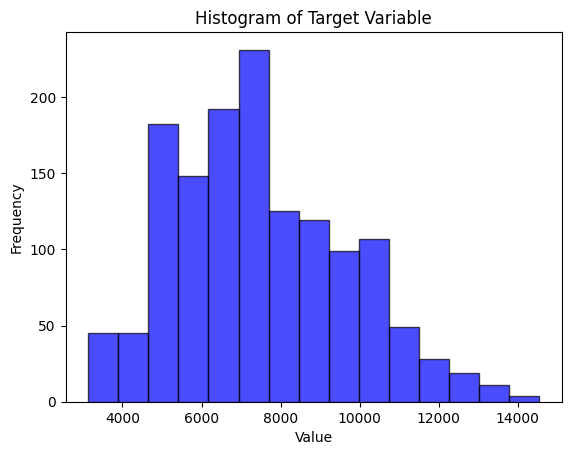

In [ ]:
# Plotting the target variable histogram

plt.hist(df2011_2023['Years of Potential Life Lost Rate'], bins=15, color='blue', alpha=0.7, edgecolor='black')  # You can adjust bins
plt.title('Histogram of Target Variable')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


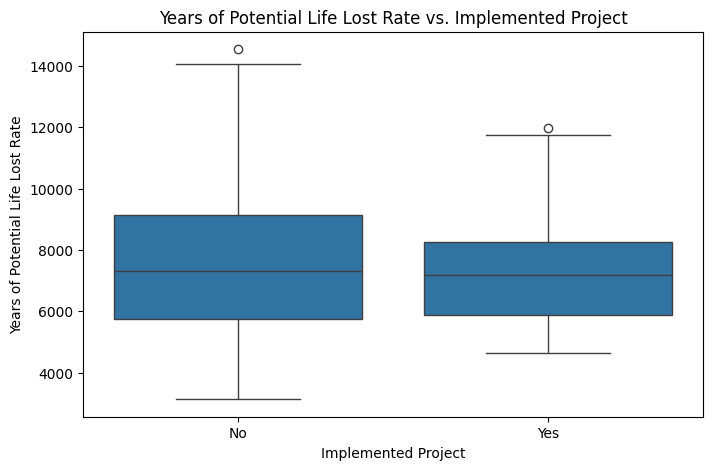

In [ ]:
#Boxplot to map the relationship between 'Implemented Project'and'Years of Potential Life Lost Rate'
plt.figure(figsize=(8, 5))
sns.boxplot(x='Implemented Project', y='Years of Potential Life Lost Rate', data=df2011_2023)
plt.title('Years of Potential Life Lost Rate vs. Implemented Project')
plt.xlabel('Implemented Project')
plt.ylabel('Years of Potential Life Lost Rate')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()


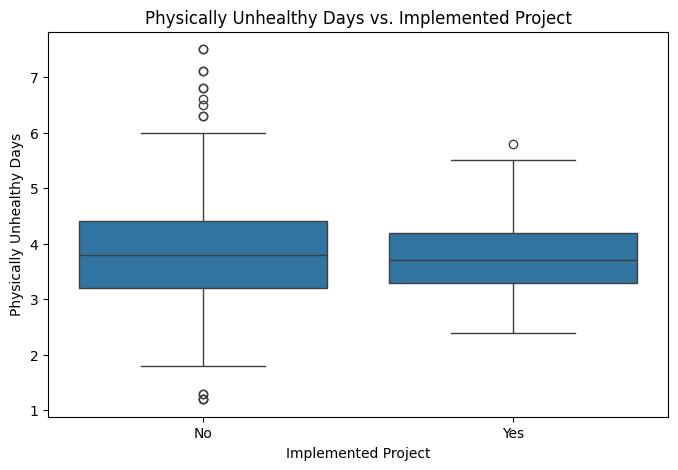

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='Implemented Project', y='Physically Unhealthy Days', data=df2011_2023)
plt.title('Physically Unhealthy Days vs. Implemented Project')
plt.xlabel('Implemented Project')
plt.ylabel('Physically Unhealthy Days')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

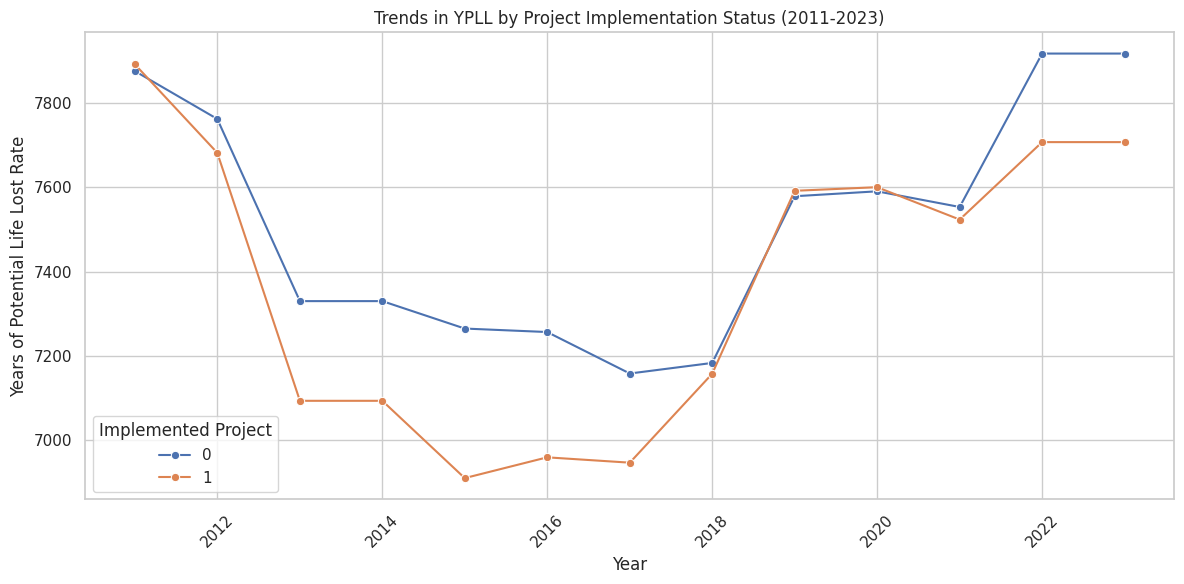

In [ ]:
#Plot trends
df2011_2023['Year'] = pd.to_datetime(df2011_2023['Year'], format='%Y')

# Group by year and the 'Implemented Project' status, and calculate the mean (or count)
grouped_data = df2011_2023.groupby(['Year', 'Implemented Project'])['Years of Potential Life Lost Rate'].mean().reset_index()

sns.set(style='whitegrid')


plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped_data, x='Year', y='Years of Potential Life Lost Rate', hue='Implemented Project', marker='o')


plt.title('Trends in YPLL by Project Implementation Status (2011-2023)')
plt.xlabel('Year')
plt.ylabel('Years of Potential Life Lost Rate')
plt.xticks(rotation=45)
plt.legend(title='Implemented Project')
plt.tight_layout()
plt.show()



In [ ]:
# View the summary statistics
print(df2011_2023['Years of Potential Life Lost Rate'].describe())

Q1 = df2011_2023['Years of Potential Life Lost Rate'].quantile(0.25)
Q3 = df2011_2023['Years of Potential Life Lost Rate'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df2011_2023[(df2011_2023['Years of Potential Life Lost Rate'] < lower_bound) | (df2011_2023['Years of Potential Life Lost Rate'] > upper_bound)]
print("Outliers based on IQR:")
print(outliers)
#Remove outliers
df2011_2023 = df2011_2023[(df2011_2023['Years of Potential Life Lost Rate'] >= lower_bound) &
                          (df2011_2023['Years of Potential Life Lost Rate'] <= upper_bound)]
print(outliers)

count     1404.000000
mean      7493.286982
std       2166.594571
min       3133.000000
25%       5775.250000
50%       7258.000000
75%       8992.500000
max      14539.000000
Name: Years of Potential Life Lost Rate, dtype: float64
Outliers based on IQR:
         State   County  Year  Years of Potential Life Lost Rate  % Fair/Poor  \
2138  Oklahoma    Caddo  2019                            13897.0         24.0   
2142  Oklahoma  Choctaw  2019                            14539.0         25.0   
383    Florida   Putnam  2022                            14058.0         27.0   
383    Florida   Putnam  2023                            14058.0         23.0   

      Physically Unhealthy Days  Mentally Unhealthy Days  % Smokers  % Obese  \
2138                        5.0                      5.0   22.00000     37.0   
2142                        5.5                      5.2   21.00000     37.0   
383                         5.6                      5.9   27.00000     37.0   
383                

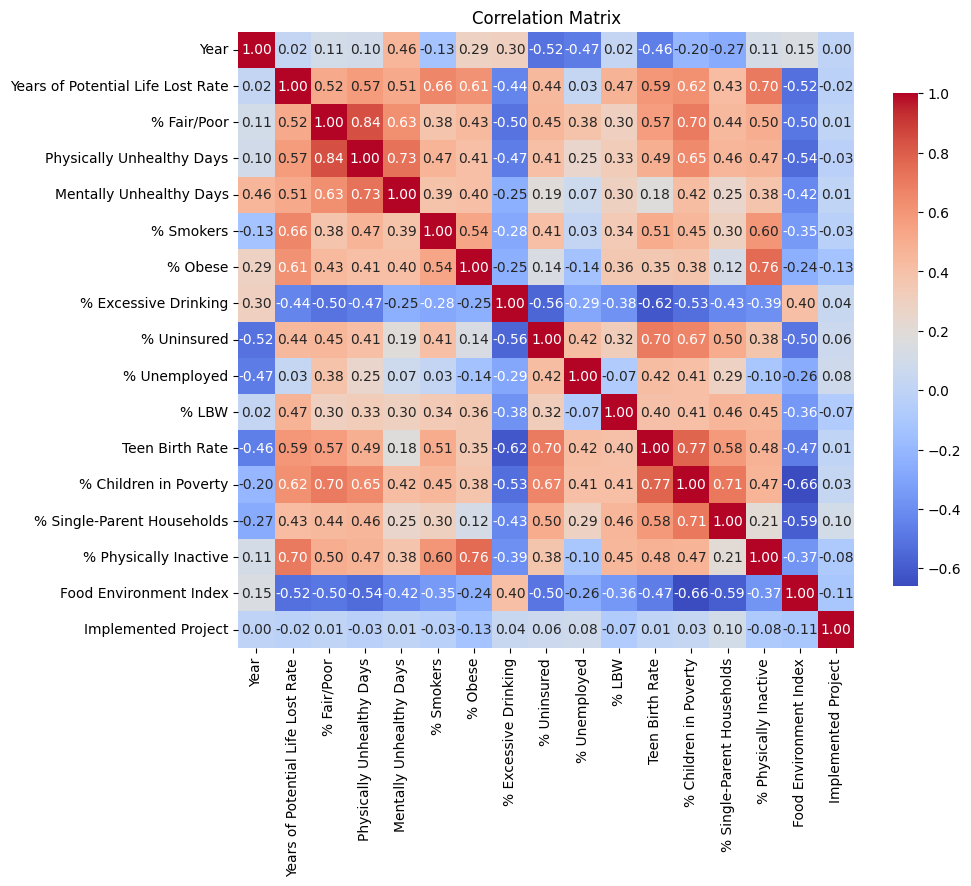

In [ ]:
# Correlation matrix
string_columns= ['State', 'County']
df_numeric= df2011_2023.drop(columns=string_columns)

correlation_matrix = df_numeric.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()


In [ ]:
# Calculate VIF for each feature
df_numeric.drop(columns=['Years of Potential Life Lost Rate'], inplace=True)
df_numeric.drop(columns=['Year'], inplace=True)
X = df_numeric.select_dtypes(include=[np.number])

# Add a constant (intercept term)
X = add_constant(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                       feature         VIF
0                        const  486.358677
1                  % Fair/Poor    5.112595
2    Physically Unhealthy Days    5.202458
3      Mentally Unhealthy Days    2.810795
4                    % Smokers    2.139769
5                      % Obese    2.992883
6         % Excessive Drinking    1.969584
7                  % Uninsured    2.679028
8                 % Unemployed    1.871292
9                        % LBW    1.688071
10             Teen Birth Rate    4.347208
11       % Children in Poverty    5.526006
12  % Single-Parent Households    2.742849
13       % Physically Inactive    3.654972
14      Food Environment Index    2.132330
15         Implemented Project    1.072942


In [ ]:

# Step 1: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# Step 2: Fit PCA
pca = PCA(n_components=None)  # Use 'None' to keep all components initially
X_pca = pca.fit_transform(X_scaled)

# Step 3: Analyze explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)


# Step 4: Choose the number of components (e.g., keep components explaining 95% of variance)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components explaining 95% variance: {n_components}")

# Step 5: Fit PCA with the chosen number of components
pca = PCA(n_components=n_components)
X_pca_reduced = pca.fit_transform(X_scaled)

# Create a DataFrame with the reduced components
pca_df = pd.DataFrame(X_pca_reduced, columns=[f'PC{i+1}' for i in range(n_components)])
print(pca_df.head())


Number of components explaining 95% variance: 11
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.527764  1.533593 -0.620389 -0.588885  0.370476 -0.233961  0.264903   
1  0.237942  1.624936 -0.102414 -0.977169 -0.422518  0.605586  0.670052   
2 -1.208154  0.764711  0.295367 -0.809890  0.018639 -0.175435  0.204709   
3 -2.611709  1.581138 -1.271846 -0.718941 -0.504773  0.280981  0.504498   
4  1.616227  2.211404 -0.228594 -1.378927 -0.366103  0.236338 -0.855586   

        PC8       PC9      PC10      PC11  
0 -0.326844  0.917095 -0.038628 -0.349284  
1 -0.486280  0.020355 -0.448348  0.525065  
2 -0.476021  0.944859  0.158957  0.075503  
3 -0.807452  1.301928 -0.206703 -0.378131  
4  0.634811  0.303911  0.529698  0.095408  


In [ ]:
df2011_2023['Years of Potential Life Lost Rate'] = np.log1p(df2011_2023['Years of Potential Life Lost Rate'])


In [ ]:
df2011_2023.drop(columns=['Year'], inplace=True)

In [ ]:
#Baseline Ridge Regression

features = [ '% Fair/Poor', 'Physically Unhealthy Days', 'Mentally Unhealthy Days',
            '% Smokers', '% Obese', '% Excessive Drinking',
            '% Uninsured', '% Unemployed', '% LBW',
            'Food Environment Index', '% Physically Inactive', 'Teen Birth Rate',
              '% Children in Poverty', '% Single-Parent Households','Implemented Project' ]
target = 'Years of Potential Life Lost Rate'


y = df2011_2023[target]
X = df2011_2023[features]

train_end_idx = 1081
y_train_ridge, y_test_ridge = y.iloc[:train_end_idx], y.iloc[train_end_idx:]
X_train_ridge, X_test_ridge = X.iloc[:train_end_idx], X.iloc[train_end_idx:]

scaler= StandardScaler()
X_train_ridge = scaler.fit_transform(X_train_ridge)
X_test_ridge = scaler.fit_transform(X_test_ridge)

model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train_ridge, y_train_ridge)

y_pred_ridge = model_ridge.predict(X_test_ridge)

mae_ridge = mean_absolute_error(y_test_ridge, y_pred_ridge)
mse_ridge = mean_squared_error(y_test_ridge, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)

r_squared_ridge = r2_score(y_test_ridge, y_pred_ridge)

print(f'MAE: {mae_ridge:.4f}')
print(f'RMSE: {rmse_ridge:.4f}')
print(f"R-squared: {r_squared_ridge:.4f}")


MAE: 0.1328
RMSE: 0.1687
R-squared: 0.6801


In [ ]:
#GridsearchCV on Ridge


tscv = TimeSeriesSplit(n_splits=5)

model_ridge= Ridge()

# Define the hyperparameter grid
param_grid = {
   'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],

}

grid_search = GridSearchCV(
   estimator=model_ridge,
   param_grid=param_grid,
   cv=tscv,
   scoring='neg_mean_squared_error',
   n_jobs=-1,
   verbose=1
)

scaler= StandardScaler()
X_train_ridge = scaler.fit_transform(X_train_ridge)
X_test_ridge = scaler.fit_transform(X_test_ridge)


grid_search.fit(X_train_ridge, y_train_ridge)


best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


print("Best Parameters:", best_params)



y_pred_ridge = best_model.predict(X_test_ridge)


mae_ridge_cv = mean_absolute_error(y_test_ridge, y_pred_ridge)
rmse_ridge_cv = np.sqrt(mean_squared_error(y_test_ridge, y_pred_ridge))
r_squared_ridge_cv = r2_score(y_test_ridge, y_pred_ridge)


print(f"MAE: {mae_ridge_cv:.4f}")
print(f"RMSE: {rmse_ridge_cv:.4f}")
print(f"R-squared: {r_squared_ridge_cv:.4f}")

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Parameters: {'alpha': 100}
MAE: 0.1334
RMSE: 0.1691
R-squared: 0.6785


In [ ]:
#Baseline RF
features = [ '% Fair/Poor', 'Physically Unhealthy Days', 'Mentally Unhealthy Days',
            '% Smokers', '% Obese', '% Excessive Drinking',
            '% Uninsured', '% Unemployed', '% LBW',
            'Food Environment Index', '% Physically Inactive', 'Teen Birth Rate',
              '% Children in Poverty', '% Single-Parent Households','Implemented Project' ]
target = 'Years of Potential Life Lost Rate'
features_rf = features

y = df2011_2023[target]
X = df2011_2023[features]


train_end_idx = 1081
y_train_rf, y_test_rf = y.iloc[:train_end_idx], y.iloc[train_end_idx:]
X_train_rf, X_test_rf = X.iloc[:train_end_idx], X.iloc[train_end_idx:]

scaler= StandardScaler()
X_train_rf = scaler.fit_transform(X_train_rf)
X_test_rf = scaler.fit_transform(X_test_rf)


model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train_rf, y_train_rf)


y_pred_rf = model_rf.predict(X_test_rf)


mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)
mse_rf = mean_squared_error(y_test_rf, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test_rf, y_pred_rf)

print(f'MAE: {mae_rf:.4f}')
print(f'RMSE: {rmse_rf:.4f}')
print(f'R-squared: {r2_rf:.4f}')

MAE: 0.1169
RMSE: 0.1545
R-squared: 0.7318


In [ ]:
#RF after PCA

features = pca_df.columns
target = 'Years of Potential Life Lost Rate'

y = df2011_2023[target]
X = pca_df[features]


train_end_idx = 1081
y_train_rf, y_test_rf = y.iloc[:train_end_idx], y.iloc[train_end_idx:]
X_train_rf, X_test_rf = X.iloc[:train_end_idx], X.iloc[train_end_idx:]

scaler= StandardScaler()
X_train_rf = scaler.fit_transform(X_train_rf)
X_test_rf = scaler.fit_transform(X_test_rf)

model_rf2 = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf2.fit(X_train_rf, y_train_rf)

y_pred_rf = model_rf2.predict(X_test_rf)


mae_rf2 = mean_absolute_error(y_test_rf, y_pred_rf)
mse_rf2 = mean_squared_error(y_test_rf, y_pred_rf)
rmse_rf2 = np.sqrt(mse_rf2)
r2_2 = r2_score(y_test_rf, y_pred_rf)

print(f'MAE: {mae_rf2:.4f}')
print(f'RMSE: {rmse_rf2:.4f}')
print(f'R-squared: {r2_2:.4f}')

MAE: 0.1173
RMSE: 0.1486
R-squared: 0.7519


In [ ]:
#GridSearchCV for RF

model_rf2 = RandomForestRegressor(random_state=42)


param_grid = {
    'n_estimators': [ 250, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


tscv = TimeSeriesSplit(n_splits=5)


grid_search = GridSearchCV(estimator=model_rf2, param_grid=param_grid, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error')

scaler= StandardScaler()
X_train_rf = scaler.fit_transform(X_train_rf)
X_test_rf = scaler.fit_transform(X_test_rf)

grid_search.fit(X_train_rf, y_train_rf)


best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

y_pred_rf = best_model.predict(X_test_rf)

mae_rf_cv = mean_absolute_error(y_test_rf, y_pred_rf)
rmse_rf_cv = mean_squared_error(y_test_rf, y_pred_rf, squared=False)
r_squared_rf_cv = r2_score(y_test_rf, y_pred_rf)

print(f"MAE: {mae_rf_cv:.4f}")
print(f"RMSE: {rmse_rf_cv:.4f}")
print(f"R-squared: {r_squared_rf_cv:.4f}")


Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}
MAE: 0.1167
RMSE: 0.1480
R-squared: 0.7539


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
#Baseline XGBOOST
features = [ '% Fair/Poor', 'Physically Unhealthy Days', 'Mentally Unhealthy Days',
            '% Smokers', '% Obese', '% Excessive Drinking',
            '% Uninsured', '% Unemployed', '% LBW',
            'Food Environment Index', '% Physically Inactive', 'Teen Birth Rate',
              '% Children in Poverty', '% Single-Parent Households','Implemented Project' ]
target = 'Years of Potential Life Lost Rate'
features_xgb = features
y = df2011_2023[target]
X = df2011_2023[features]

train_end_idx = 1081
y_train_xgb, y_test_xgb = y.iloc[:train_end_idx], y.iloc[train_end_idx:]
X_train_xgb, X_test_xgb = X.iloc[:train_end_idx], X.iloc[train_end_idx:]

scaler= StandardScaler()
X_train_xgb = scaler.fit_transform(X_train_xgb)
X_test_xgb = scaler.fit_transform(X_test_xgb)


model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model_xgb.fit(X_train_xgb, y_train_xgb)

y_pred_xgb = model_xgb.predict(X_test_xgb)


mae_xgb = mean_absolute_error(y_test_xgb, y_pred_xgb)
mse_xgb = mean_squared_error(y_test_xgb, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

r_squared_xgb = r2_score(y_test_xgb, y_pred_xgb)

print(f'MAE: {mae_xgb:.4f}')
print(f'RMSE: {rmse_xgb:.4f}')
print(f"R-squared: {r_squared_xgb:.4f}")

MAE: 0.1225
RMSE: 0.1629
R-squared: 0.7018


In [ ]:
#XGBOOST after PCA

features = pca_df.columns
target = 'Years of Potential Life Lost Rate'

y = df2011_2023[target]
X = pca_df[features]

train_end_idx = 1081
y_train_xgb, y_test_xgb = y.iloc[:train_end_idx], y.iloc[train_end_idx:]
X_train_xgb, X_test_xgb = X.iloc[:train_end_idx], X.iloc[train_end_idx:]

scaler= StandardScaler()
X_train_xgb = scaler.fit_transform(X_train_xgb)
X_test_xgb = scaler.fit_transform(X_test_xgb)


model_xgb3 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model_xgb3.fit(X_train_xgb, y_train_xgb)


y_pred_xgb = model_xgb3.predict(X_test_xgb)


mae_xgb3 = mean_absolute_error(y_test_xgb, y_pred_xgb)
mse_xgb3 = mean_squared_error(y_test_xgb, y_pred_xgb)
rmse_xgb3 = np.sqrt(mse_xgb3)

r_squared_xgb3 = r2_score(y_test_xgb, y_pred_xgb)

print(f'MAE: {mae_xgb3:.4f}')
print(f'RMSE: {rmse_xgb3:.4f}')
print(f"R-squared: {r_squared_xgb3:.4f}")

MAE: 0.1185
RMSE: 0.1534
R-squared: 0.7354


In [ ]:
#GridSearchCV for XGBoost on model after PCA

tscv = TimeSeriesSplit(n_splits=5)


model_xgb3= xgb.XGBRegressor(objective='reg:squarederror', random_state=42)


param_grid = {
   'n_estimators': [100, 150, 200],
   'max_depth': [5, 7, 9],
   'learning_rate': [0.01, 0.1, 0.2],
   'subsample': [0.8, 1.0]
}


grid_search = GridSearchCV(
   estimator=model_xgb3,
   param_grid=param_grid,
   cv=tscv,
   scoring='neg_mean_squared_error',
   n_jobs=-1,
   verbose=1
)

scaler= StandardScaler()
X_train_xgb = scaler.fit_transform(X_train_xgb)
X_test_xgb = scaler.fit_transform(X_test_xgb)


grid_search.fit(X_train_xgb, y_train_xgb)


best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


print("Best Parameters:", best_params)


y_pred_xgb = best_model.predict(X_test_xgb)


mae_xgb_cv = mean_absolute_error(y_test_xgb, y_pred_xgb)
rmse_xgb_cv = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))
r_squared_xgb_cv = r2_score(y_test_xgb, y_pred_xgb)


print(f"MAE: {mae_xgb_cv:.4f}")
print(f"RMSE: {rmse_xgb_cv:.4f}")
print(f"R-squared: {r_squared_xgb_cv:.4f}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
MAE: 0.1195
RMSE: 0.1519
R-squared: 0.7406


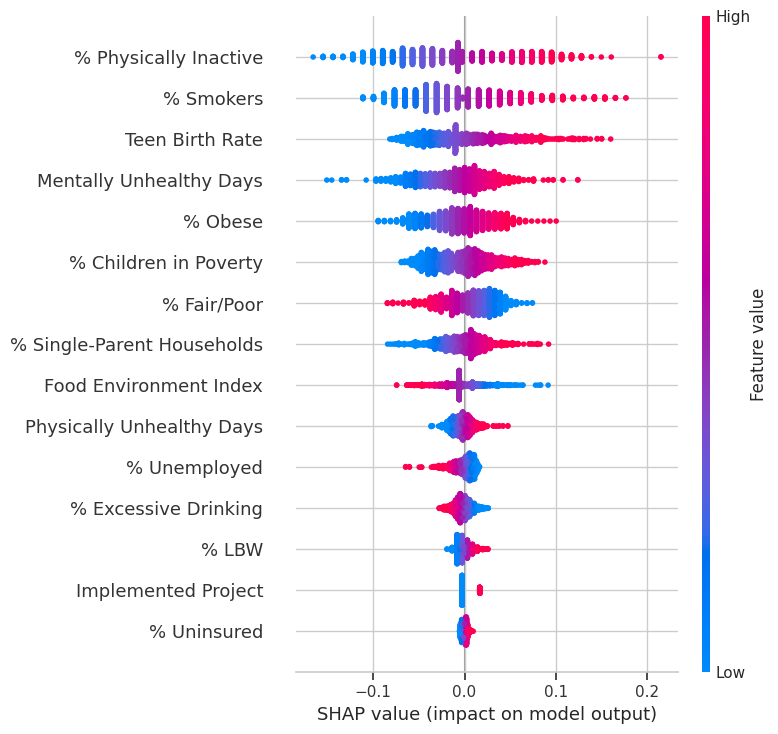

<Figure size 640x480 with 0 Axes>

In [ ]:
#SHAP values for Ridge

explainer_ridge = shap.Explainer(best_model, X_train_ridge, feature_names= features)
shap_values_ridge = explainer_ridge(X_train_ridge)
shap.summary_plot(shap_values_ridge, X_train_ridge)

plt.savefig('SHAP Ridge.jpg')

 99%|===================| 1074/1081 [00:51<00:00]       

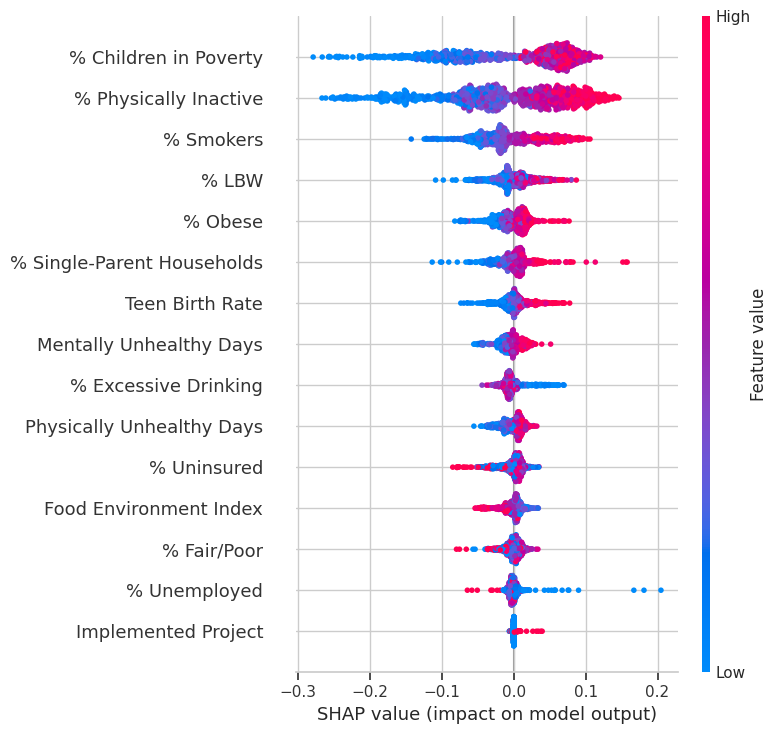

<Figure size 640x480 with 0 Axes>

In [ ]:
#SHAP values for RF

explainer_rf = shap.Explainer(model_rf, X_train_rf, feature_names = features_rf)
shap_values_rf = explainer_rf(X_train_rf)

shap.summary_plot(shap_values_rf, X_train_rf)

plt.savefig('SHAP Random Forest.jpg')

 99%|===================| 1072/1081 [00:32<00:00]       

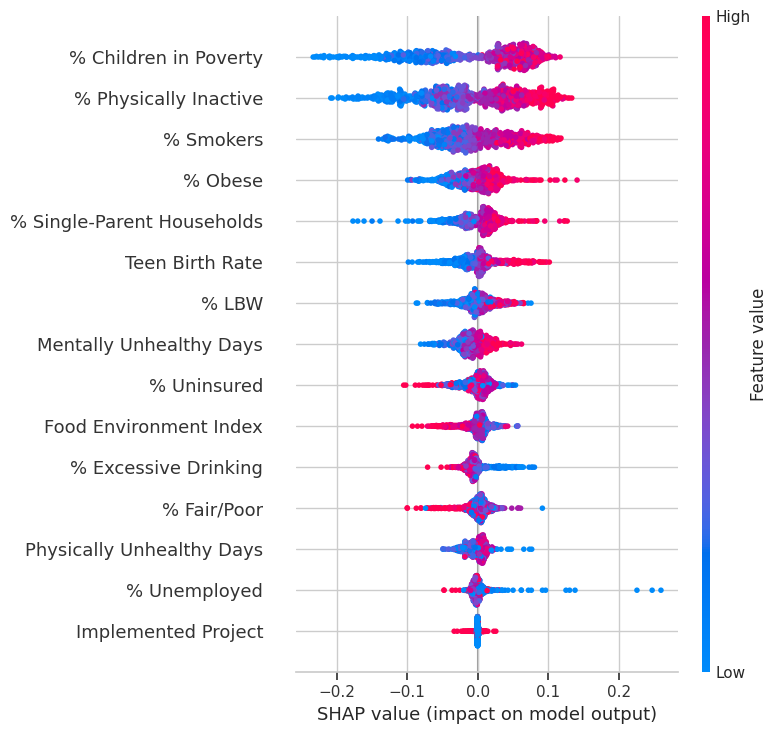

<Figure size 640x480 with 0 Axes>

In [ ]:
#SHAP values for XGBOOST
explainer_xgb = shap.Explainer(model_xgb, X_train_xgb, feature_names= features_xgb)
shap_values_xgb = explainer_xgb(X_train_xgb)

shap.summary_plot(shap_values_xgb, X_train_xgb)

plt.savefig('SHAP XGBoost.jpg')


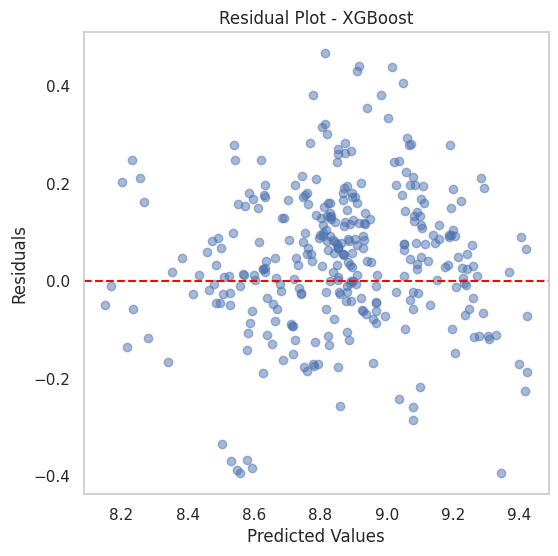

In [ ]:
# Residual Plot - XGBoost
residuals_xgb = y_test_xgb - y_pred_xgb

plt.figure(figsize=(6, 6))
plt.scatter(y_pred_xgb, residuals_xgb, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')  # Horizontal line at 0 for reference
plt.title('Residual Plot - XGBoost')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid()
plt.show()


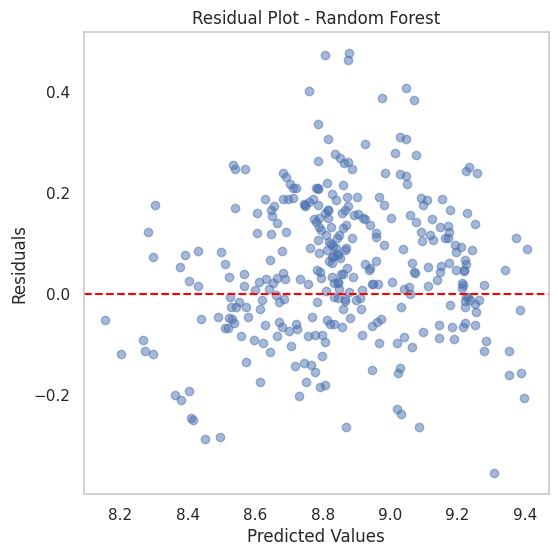

In [ ]:
# Residual Plot - Random Forest
residuals_rf = y_test_rf - y_pred_rf


plt.figure(figsize=(6, 6))
plt.scatter(y_pred_rf, residuals_rf, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot - Random Forest')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid()
plt.show()

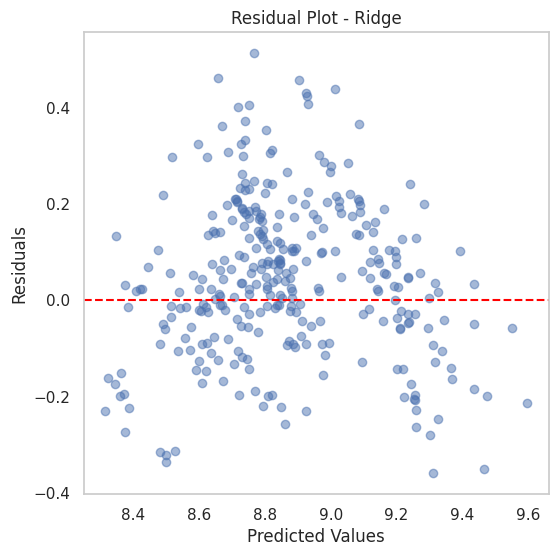

In [ ]:
# Residual Plot - Ridge
residuals_ridge = y_test_ridge - y_pred_ridge


plt.figure(figsize=(6, 6))
plt.scatter(y_pred_ridge, residuals_ridge, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot - Ridge')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid()
plt.show()